## A notebook for 02-feature-inversion

This notebook shows how to carry out a simple experiment on feature inversion.

In [1]:
import os
import tensorflow as tf
import numpy as np
import custom_vgg16_bn as vgg16
import cv2
import matplotlib.pyplot as plt

## Configuration

In [2]:
nr_channel = 3
nr_epoch = 2000
show_interval = 20
weights_path = "/../../models/vgg16_onnx.npy"

In [3]:
vgg_mean = [0.485, 0.456, 0.406]
vgg_std = [0.229, 0.224, 0.225] ### The pretrained model needs input normalization.
data = None

## Defining the model for extracting features and generating representation

In [4]:
class Vgg16:
    def __init__(self, vgg16_npy_path=None):
        global data

        if vgg16_npy_path is None:
            path = weights_path

            if os.path.exists(path):
                vgg16_npy_path = path

            else:
                print("VGG16 weights were not found in the project directory!")
                exit(0)

        if data is None:
            data = np.load(vgg16_npy_path, encoding='latin1')
            self.data_dict = data.item()
            print("VGG16 weights loaded")

        else:
            self.data_dict = data.item()

    def build(self, bgr_input):
        '''notice that opencv load image with bgr order, but the pretrained model is designed for rgb'''
        blue, green, red = tf.split(axis=3, num_or_size_splits=3, value=bgr_input)

        rgb = tf.concat(axis=3, values=[
            (red - vgg_mean[0])/vgg_std[0],
            (green - vgg_mean[1])/vgg_std[1],
            (blue - vgg_mean[2])/vgg_std[2],
        ])


        self.conv1_1 = self.conv_layer(rgb, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
        self.pool1 = self.avg_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
        self.pool2 = self.avg_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")

        self.pool3 = self.avg_pool(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")

        self.pool4 = self.avg_pool(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")

        self.data_dict = None

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom,
            ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, name, stride = 1):
        with tf.variable_scope(name):
            filt = self.get_conv_filter(name)

            conv = tf.nn.conv2d(bottom, filt, [1, stride, stride, 1], padding='SAME')
            conv_biases = self.get_bias(name)
            bias = tf.nn.bias_add(conv, conv_biases)
            mean = self.get_mean(name)
            variance = self.get_variance(name)
            offset = self.get_beta(name)
            scale = self.get_gamma(name)
            norm = tf.nn.batch_normalization(bias, mean, variance, offset, scale, 1e-20 )
            relu = tf.nn.relu(norm)
            return relu

    def fc_layer(self, bottom, name):
        with tf.variable_scope(name):
            shape = bottom.get_shape().as_list()
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(bottom, [-1, dim])

            weights = self.get_fc_weight(name)
            biases = self.get_bias(name)

            # Fully connected layer. Note that the '+' operation automatically
            # broadcasts the biases.
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_mean(self, name):
        return tf.constant(self.data_dict[name][4], name = "mean")

    def get_variance(self, name):
        return tf.constant(self.data_dict[name][5], name = "variance")

    def get_gamma(self, name):
        return tf.constant(self.data_dict[name][2], name = "gamma")

    def get_beta(self, name):
        return tf.constant(self.data_dict[name][3], name = "beta")

    def get_conv_filter(self, name):
        return tf.constant(np.rollaxis(np.rollaxis(np.rollaxis(self.data_dict[name][0], 1), 2), 3), name="filter")

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name="biases")

    def get_fc_weight(self, name):
        return tf.constant(np.rollaxis(self.data_dict[name][0], 1), name="weights")



In [5]:
'''use conv3_1 to extract features and generate representation'''
FEATURE_LAYERS = ['conv3_1']
image_shape = (1, 224, 224, 3)


In [6]:
def get_feature_loss(noise,source):
    with tf.name_scope('get_feature_loss'):
        feature_loss = [get_l2_loss_for_layer(noise, source, layer)for layer in FEATURE_LAYERS]
    return tf.reduce_mean(tf.convert_to_tensor(feature_loss))

def get_l2_loss_for_layer(noise, source, layer):
    noise_layer = getattr(noise,layer)
    source_layer = getattr(source, layer)
    l2_loss = tf.reduce_mean((source_layer-noise_layer) **2)
    return  l2_loss

def output_img(session, x, save=False, out_path=None):
    shape = image_shape
    img = np.clip(session.run(x),0, 1) * 255
    img = img.astype('uint8')
    if save:
        cv2.imwrite(out_path, (np.reshape(img, shape[1:])))

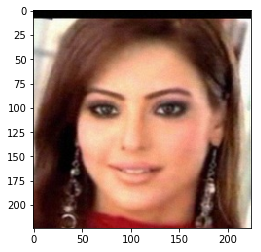

In [7]:
 '''training from noise'''
pre_noise = tf.Variable(tf.random_uniform(image_shape, -3, 3 ))
noise = tf.Variable(tf.nn.sigmoid(pre_noise))

'''load target image, notice that the pixel value has to be normalized to [0,1]'''
image = cv2.imread('../../images/face.jpg')

image = cv2.resize(image, image_shape[1:3])
img_show = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2RGB)
                        
plt.figure()
plt.imshow(img_show)
plt.show()

image = image.reshape(image_shape)
image = (image/255).astype('float32')



VGG16 weights loaded
e:20 loss: 0.01566
e:40 loss: 0.01446
e:60 loss: 0.01340
e:80 loss: 0.01248
e:100 loss: 0.01167
e:120 loss: 0.01095
e:140 loss: 0.01032
e:160 loss: 0.00976
e:180 loss: 0.00925
e:200 loss: 0.00879
e:220 loss: 0.00837
e:240 loss: 0.00799
e:260 loss: 0.00764
e:280 loss: 0.00732
e:300 loss: 0.00702
e:320 loss: 0.00675
e:340 loss: 0.00650
e:360 loss: 0.00627
e:380 loss: 0.00606
e:400 loss: 0.00586
e:420 loss: 0.00567
e:440 loss: 0.00550
e:460 loss: 0.00533
e:480 loss: 0.00518
e:500 loss: 0.00503
e:520 loss: 0.00490
e:540 loss: 0.00477
e:560 loss: 0.00465
e:580 loss: 0.00453
e:600 loss: 0.00442
e:620 loss: 0.00431
e:640 loss: 0.00421
e:660 loss: 0.00411
e:680 loss: 0.00401
e:700 loss: 0.00392
e:720 loss: 0.00383
e:740 loss: 0.00374
e:760 loss: 0.00365
e:780 loss: 0.00357
e:800 loss: 0.00349
e:820 loss: 0.00342
e:840 loss: 0.00334
e:860 loss: 0.00327
e:880 loss: 0.00319
e:900 loss: 0.00312
e:920 loss: 0.00305
e:940 loss: 0.00298
e:960 loss: 0.00291
e:980 loss: 0.00284
e:1

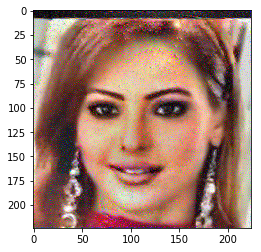

In [8]:

'''get representation of the target image, which the noise image will approximate'''
with tf.name_scope('vgg_src'):
    image_model = vgg16.Vgg16()
    image_model.build(image)
    
'''get representation of the noise image'''
with tf.name_scope('vgg_noise'):
    noise_model = vgg16.Vgg16()
    noise_model.build(noise)

'''compute representation difference between noise feature and target feature'''
with tf.name_scope('loss'):
    loss = get_feature_loss(noise_model, image_model)

total_loss = loss

global_steps = tf.Variable(0, trainable = False)
lr = 0.001

with tf.name_scope('update_image'):
    opt = tf.train.AdamOptimizer(lr)
    grads = opt.compute_gradients(total_loss, [noise])
    update_image = opt.apply_gradients(grads)


tf.set_random_seed(12345) 
global_cnt = 0
epoch_start = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # init all variables
       
    '''start training'''
    for epoch in range(epoch_start+1, nr_epoch+1):
        global_cnt += 1
        _, loss =  sess.run([update_image, total_loss],
                                        feed_dict ={ global_steps: global_cnt} )

        if global_cnt % show_interval == 0:
            print(
                "e:{}".format(epoch),'loss: {:.5f}'.format(loss),
            )
            
        
           
    print('Training is done, exit.')
    img = np.clip(sess.run(noise),0, 1) * 255
    img_approximated = cv2.cvtColor(img[0].astype('uint8'), cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img_approximated)
    plt.show()